In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.1,  # Desplazamiento horizontal del 10%
    height_shift_range=0.1,  # Desplazamiento vertical del 10%
    shear_range=0.1,  # Transformación de cizallamiento del 10%
    zoom_range=0.1,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    brightness_range=[0.1, 1.0]  # Ajuste de brillo entre 0.1 y 1.0
)
 # Evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado ResNet50V2
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelamos las capas del modelo base

In [5]:
# Construcción del modelo
x = base_model.layers[-117].output #Equivalent to two (2) CORE block deduction.

# Capa convolucional
x = Conv2D(filters=192, kernel_size=6, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=3, strides=3, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.2)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50v2_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 # Puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
400/400 [==============================] - 71s 167ms/step - loss: 0.9973 - accuracy: 0.5825 - val_loss: 0.4316 - val_accuracy: 0.8195 - lr: 1.0000e-05
Epoch 2/500
400/400 [==============================] - 44s 110ms/step - loss: 0.6414 - accuracy: 0.7362 - val_loss: 0.4263 - val_accuracy: 0.8305 - lr: 1.0000e-05
Epoch 3/500
400/400 [==============================] - 43s 108ms/step - loss: 0.5383 - accuracy: 0.7831 - val_loss: 0.4062 - val_accuracy: 0.8415 - lr: 1.0000e-05
Epoch 4/500
400/400 [==============================] - 43s 108ms/step - loss: 0.4613 - accuracy: 0.8134 - val_loss: 0.5714 - val_accuracy: 0.7755 - lr: 1.0000e-05
Epoch 5/500
400/400 [==============================] - 43s 108ms/step - loss: 0.4513 - accuracy: 0.8125 - val_loss: 0.3523 - val_accuracy: 0.8550 - lr: 1.0000e-05
Epoch 6/500
400/400 [==============================] - 44s 110ms/step - loss: 0.4140 - accuracy: 0.8366 - val_loss: 0.3574 - val_accuracy: 0.8560 - lr: 1.0000e-05
Epoch 7/500
400/400 [=

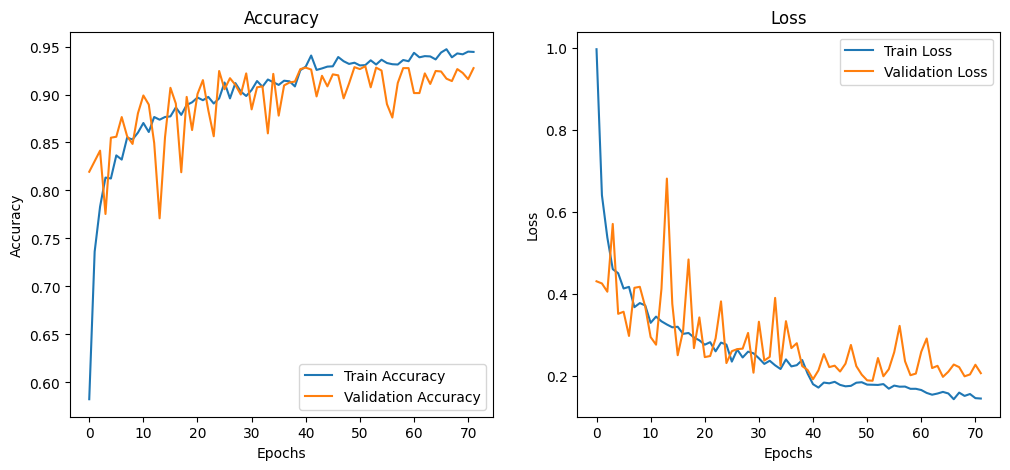

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo
model.save("resnet50v2_gastro_model.h5")
print("Modelo guardado")

Modelo guardado


In [12]:
# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

100/100 [==============================] - 8s 76ms/step - loss: 0.1862 - accuracy: 0.9325
Test Accuracy: 93.25%
250/250 [==============================] - 10s 38ms/step - loss: 0.1892 - accuracy: 0.9295
Validation Accuracy: 92.95%


In [13]:
# Cargar el modelo guardado y probarlo
test_model = keras.models.load_model("resnet50v2_gastro_model.h5")

In [14]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(test_model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(test_model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))

100/100 [==============================] - 4s 38ms/step

Validation Classification Report:
                      precision    recall  f1-score   support

            0_normal       1.00      0.98      0.99       500
1_ulcerative_colitis       0.89      0.86      0.87       500
            2_polyps       0.87      0.87      0.87       500
       3_esophagitis       0.97      1.00      0.98       500

            accuracy                           0.93      2000
           macro avg       0.93      0.93      0.93      2000
        weighted avg       0.93      0.93      0.93      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       1.00      0.99      0.99       200
1_ulcerative_colitis       0.89      0.86      0.88       200
            2_polyps       0.87      0.88      0.87       200
       3_esophagitis       0.97      1.00      0.98       200

            accuracy                           0.93       800
       

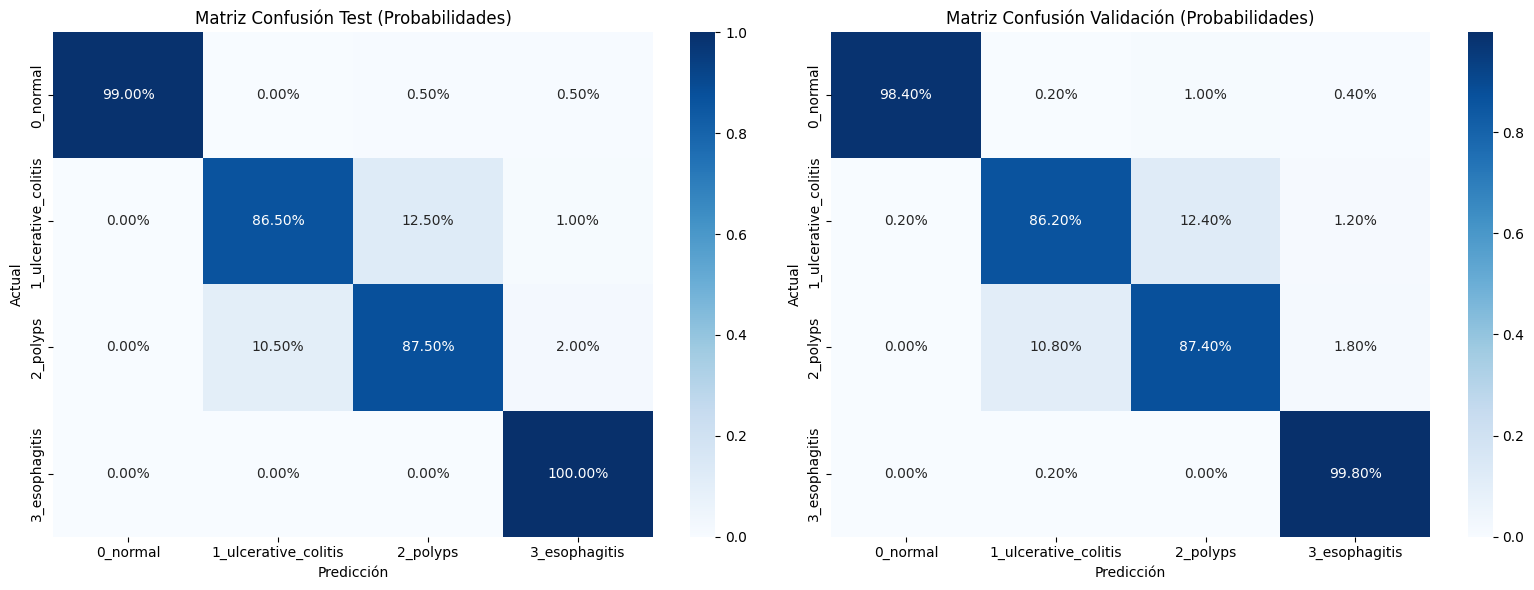

In [15]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()